## Activations(forward pass), Gradients(backward pass), Batchnorm

2024.07.31

语言模型在transformer前的中流砥柱，RNN和他的变体GRU、LSTM

为什么在介绍RNN之前需要介绍模型训练中的activation和gradient,这对于理解RNN系列网络发展历史很有帮助。虽然RNN网络的表示能力非常强(very expressive, they are universal approximator and can in priciple inplement all the algorithms)，但是这一类网络使用一阶导数梯度下降很难优化,理解这一点的核心就是理解训练中的activations,gradients,后面的网络都是来解决这一类问题

数学原理：
1. $Var[x]=E[x^2]-(E[x])^2,E[x^2]=Var[x]+(E[x])^2$
2. x和y相互独立：$E[x+y]=E[x]+E[y], E[xy]=E[x]E[y], Var[x+y]=Var[x]+Var[y]$ 期望可拆和、可拆乘积，方差只能拆为不同的和

数学背景，对于某一层的第i个神经元不加激活函数，从n个神经元变到n'个神经元，只通过矩阵乘法之后的概率分布变化如下：

假设: each input element $x_j$ and neuron weights $W_ij$ are all iid of normal distribution 

$y_i=\sum\limits_{j}W_{ij}x_j, Var[y_i] = Var[\sum\limits_{j}W_{ij}x_j]$ **definition**
 
$Var[y_i]=\sum\limits_{j}Var[W_{ij}x_j]$  **independence**

$Var[W_{ij}x_j]=E[(W_{ij}x_j)^2] - (E[W_{ij}x_j])^2=E[W_{ij}^2]E[x_j]^2=Var[W_ij]Var[x_j]$ **$W_{ij},x_j$ independence, zero mean**

$Var[y]=nVar[w]Var[x]$ **identical distributions**

经过许多layers之后 : $Var[y]=(\Pi_{d}n_d Var[w_d])Var[x]$,因此每一层用标准高斯分布最后得到的结果虽然均值为0但是方差非常大


如果加入非线形激活函数之后, $y_i=\sum\limits_{y}W_{ij}x_j',x'=ReLU(x)$,由于ReLU(x)的均值不为0，则$Var[W_{ij}x_j']=nVar[w]E[x_j'^2]$

虽然数学上可以精准的计算初始化需要的方差，但是如此大的神经网络很难精准的初始化，所以normalization方法能够让我们不用如此精细的初始化也可以稳定的训练一个好的网络；但是看到AlphaFold2等结构，好像还是需要非常精细的网络架构

BN : gamma and beta, advantage disadvantage, momentum average

### 1.original code

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

In [9]:
# read in all the words
words = open('makemore/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
len(words)
# number of examples

32033

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [13]:
# build the database
block_size= 3 # context_window, 4 gram
def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0] * block_size # extend [0] -> [0,0,0]
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # concat two list 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(f"training shape : {Xtr.shape},{Ytr.shape}") # 0.8 training
print(f"Dev shape : {Xdev.shape},{Ydev.shape}") # 0.1 validation 
print(f"Test shape : {Xte.shape},{Yte.shape}") # 0.1 test

training shape : torch.Size([182625, 3]),torch.Size([182625])
Dev shape : torch.Size([22655, 3]),torch.Size([22655])
Test shape : torch.Size([22866, 3]),torch.Size([22866])


In [14]:
def build_transformer_dataset(words):
    # modify the dataset module to flexible datalength
    X, Y  = [], []
    for w in words:
        process_word = '.' + w + '.'
        for i in range(1,len(process_word)):
            X.append([stoi[xi] for xi in process_word[:i]])
            Y.append(stoi[process_word[i]])
    # X = torch.tensor(X)
    # Y = torch.tensor(Y)
    return X,Y
transformer_Xtr, transformer_Ytr = build_transformer_dataset(words[:n1])

In [15]:
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn(n_hidden,vocab_size,           generator=g)
b2 = torch.randn(vocab_size,                    generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [16]:
# 过去的数据我们是怎么做的？
# 1.每一个dataset切分为不同的batch,这样整体的batch基本确保每个epoch可以把dataset过一遍; 数据训练更加有效
# 2.有了dataset划分为基本的datasample, 这样其实就没有epoch这个概念，只用iteration这个概念，每次从dataset随机sample一个batch_size的数据，这样的优势是什么?

# 3.注意一个点：(2)表示数字2， (2,)才表示一个tuple, 因此torch.randint(0,Xtr.shape[0],(batch_size))会报错，而torch.randint(0,Xtr.shape[0],(batch_size,)不会报错
# same optimization
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())
    

      0 /  200000: 22.1506
  10000 /  200000: 2.7259
  20000 /  200000: 2.8236
  30000 /  200000: 2.2516
  40000 /  200000: 2.4837
  50000 /  200000: 2.3694
  60000 /  200000: 2.2290
  70000 /  200000: 2.2708
  80000 /  200000: 2.2560
  90000 /  200000: 2.2737
 100000 /  200000: 2.6148
 110000 /  200000: 1.9829
 120000 /  200000: 2.4516
 130000 /  200000: 2.4053
 140000 /  200000: 2.5885
 150000 /  200000: 2.2120
 160000 /  200000: 2.1523
 170000 /  200000: 1.8166
 180000 /  200000: 1.5322
 190000 /  200000: 2.1810


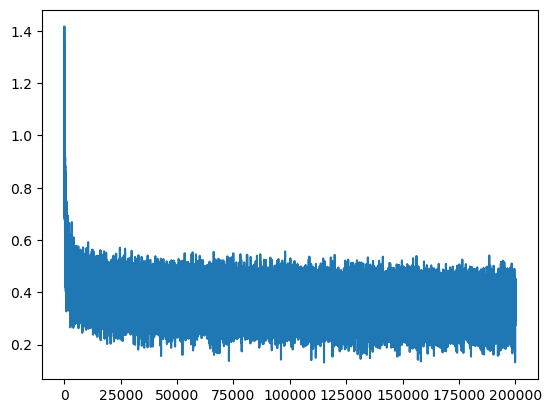

In [17]:
plt.plot(lossi)

In [18]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    h = torch.tanh(embcat@W1+b1) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('test')


train 2.25930118560791
test 2.3136303424835205


In [19]:
# sample from the model
# batch_zie = 1,从logtis中sample, 需要不断调整context_window,
g = torch.Generator().manual_seed(7777777)

for _ in range(20):
    out = []
    context = [0] *block_size #[context window] #[block_size]
    while True:
        emb = C[torch.tensor(context)] # [block_size,emb]
        embcat = emb.reshape(1,-1) # [1,block_size*emb]
        h = torch.tanh(embcat @ W1 + b1) # [1,hidden]
        logits = h @ W2 + b2 # [vocab]
        probs = F.softmax(logits,dim=-1) # [1,vocab]-prob
        # sample from distribution
        ix = torch.multinomial(probs,1,replacement=True).item()  # [1]
        # shift the context window and track the sample
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)[:-1])


mudy
fanalaatumn
narianna
jenkley
arci
brah
herry
dercharah
dakshalianganna
kaiti
kayda
rer
jenna
mamaylina
jucaiminasia
ananier
karyah
krosalanin
sabel
jarnaddolika


### 2. 最开始的Loss太高了，是因为initialization非常不好

初始化好的作用：
1. loss在刚开始训练的时候是我们理想的loss----loss刚开始更低，和uniform distribution接近
2. loss曲线并不会像一个hocky stick,因为我们拿走了网络中最简单的那一个部分,
3. 最终训练集和测试集的loss比random initialization loss更低,因为我们花了更多的cycle去真正优化模型，而不是让模型在前几个iterations只是去squashing down the weights ---- 现在weight刚开始更低，在零附近

总之，初始化好了之后，可以让模型花更多时间有效的学习，而不是浪费前面的iteration在squashing down weights上

In [20]:
# 刚开始的loss是27，非常差
# 理论上初始化之后希望得到一个uniform distribution, 概率为1/27
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [21]:
# at initialization, the nueral net is creating probability distributions that are all messed up.神经网络在初始化概率分布是乱七八糟的
# some characters are very confident and some are not confident
# basically what's happening is that the network is very confidently wrong,这也就导致了刚开始的loss非常高

In [22]:
# 测试一下4-dimensional example of the issue
logits = torch.randn(4) * 20 # confidently wrong
probs = torch.softmax(logits,dim=-1)
loss = -probs[2].log()
logits,probs,loss

(tensor([-12.7405,   1.8037, -15.5657, -22.8964]),
 tensor([4.8252e-07, 1.0000e+00, 2.8612e-08, 1.8744e-11]),
 tensor(17.3694))

In [23]:
# 核心的目的是当网络初始化的时候，我们希望logits都在zero附近，这样得到uniform distribution方便优化
# PS: 其实将logits固定为某一个正数或者某一个负数也可以，但是为了对称性，我们希望我们的logits都是0
logits = torch.tensor([0.,0.,0.,0.])
probs = torch.softmax(logits,dim=-1)
loss = -probs[2].log()
logits,probs,loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [24]:
# 重新看我们的初始化和代码------核心目标，希望logits最后在零附近,不要变成extreme value
# 1.为什么大部分模型的projection layer, bias都为False
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g)
b1 = torch.randn(n_hidden,                      generator=g) 
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())

    # ---DEBUG---
    # break
    

      0 /  200000: 2.3306
  10000 /  200000: 2.0487
  20000 /  200000: 2.3925
  30000 /  200000: 2.1285
  40000 /  200000: 1.8746
  50000 /  200000: 1.9387
  60000 /  200000: 2.3000
  70000 /  200000: 1.5932
  80000 /  200000: 1.9995
  90000 /  200000: 2.8658
 100000 /  200000: 2.3230
 110000 /  200000: 1.7577
 120000 /  200000: 2.0809
 130000 /  200000: 1.8944
 140000 /  200000: 2.1292
 150000 /  200000: 1.8225
 160000 /  200000: 2.2716
 170000 /  200000: 2.3350
 180000 /  200000: 1.6715
 190000 /  200000: 2.2642


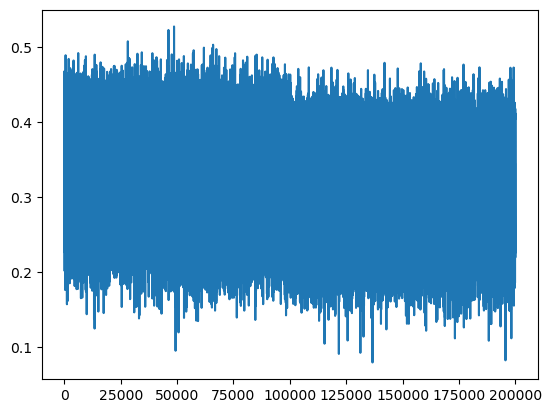

In [30]:
plt.plot(lossi)
# by andrej:
# the plot of loss doesn't have this hocky shape appearance , because what's happening in the hocky stick, the very
# first iterations of the loss what's happening during the optimization is the optimization is just squashing down the logits
# and then it's rearranging the logits. So basically we took away this easy part of the loss function, the weights were just being shrunk down.
# so therefore we don't get these easy gians at the beginning, and we're just getting some of the hard gains of training the neural nets

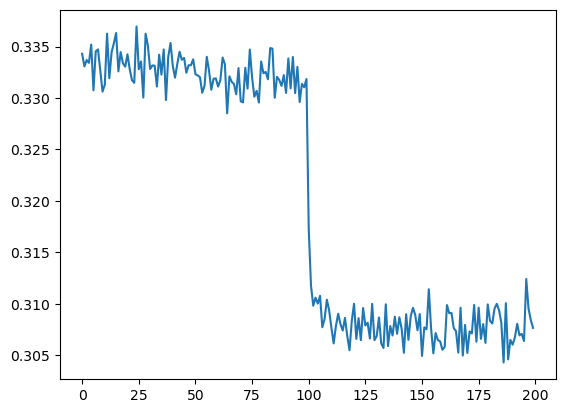

In [31]:
# reshape一下看着舒服一点，大的batchsize波动小
plt.plot(torch.tensor(lossi).reshape(-1,1000).mean(1))

In [27]:
logits[0]

tensor([-4.5033,  2.0006,  0.5422,  0.6288,  1.6747,  0.2713, -0.3512,  0.3320,
         0.4590,  0.2444,  1.8082,  2.1634,  1.0541,  1.1407,  0.7953, -0.0650,
        -0.3212, -2.3467,  0.5403,  0.3193,  0.0596, -2.4415, -0.8875, -0.9721,
        -1.5672, -0.7063,  0.6680], grad_fn=<SelectBackward0>)

In [98]:
# 注意标准初始化的结果和W2=0,b=0结果一样，但是这样初始化并不好!!!Andrej : I'm very nervous
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [107]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    h = torch.tanh(embcat@W1+b1) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('test')


train 2.1460914611816406
test 2.2219550609588623


### 3. saturated activation function tanh 

$tanh = \frac{e^{2x}-1}{e^{2x}}+1, tanh'=1-tanh^2$

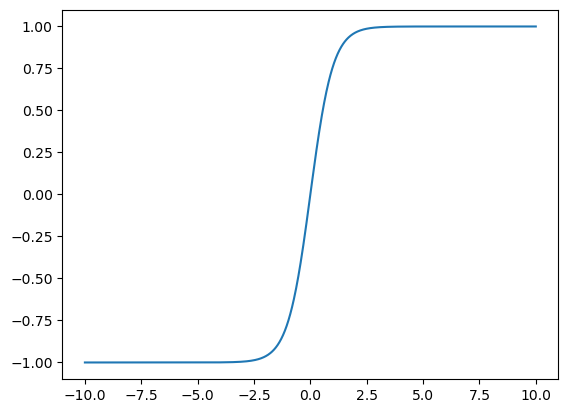

In [37]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-10, 10, 1000)
y = np.tanh(x)
plt.plot(x,y)

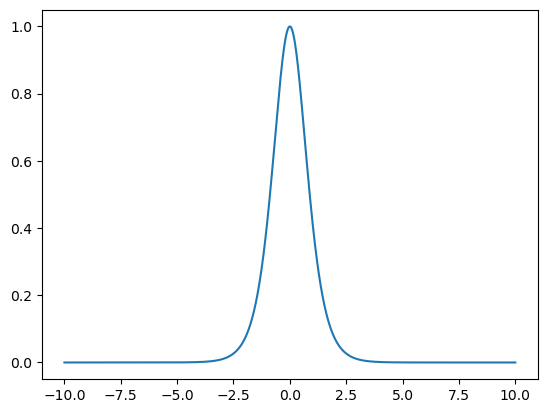

In [38]:
# gradient of tanh
y = 1 - np.tanh(x)**2
plt.plot(x,y)


In [6]:
8192 * 8192 * 4 / 1e9 * 16 * 10

42.94967296

In [144]:
# 重新看我们的初始化和代码------核心目标，希望logits最后在零附近,不要变成extreme value
# 1.为什么大部分模型的projection layer, bias都为False
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g) * 0.2 # 设置的稍微大一些，可能会有一点多样性，但是核心还是还能让hpreact在0附近
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [145]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) # h很多在1,-1之间，因此需要将hpreact变成离零很近的数值
    logits = h @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())

    # ---DEBUG---
    # break
    

      0 /  200000: 3.3204
  10000 /  200000: 1.8148
  20000 /  200000: 2.1838
  30000 /  200000: 2.0050
  40000 /  200000: 1.8666
  50000 /  200000: 2.2007
  60000 /  200000: 2.0951
  70000 /  200000: 2.5550
  80000 /  200000: 2.3031
  90000 /  200000: 1.8860
 100000 /  200000: 1.7799
 110000 /  200000: 2.2700
 120000 /  200000: 2.0954
 130000 /  200000: 1.9765
 140000 /  200000: 2.1081
 150000 /  200000: 1.9246
 160000 /  200000: 1.9466
 170000 /  200000: 2.0160
 180000 /  200000: 2.3037
 190000 /  200000: 2.1909


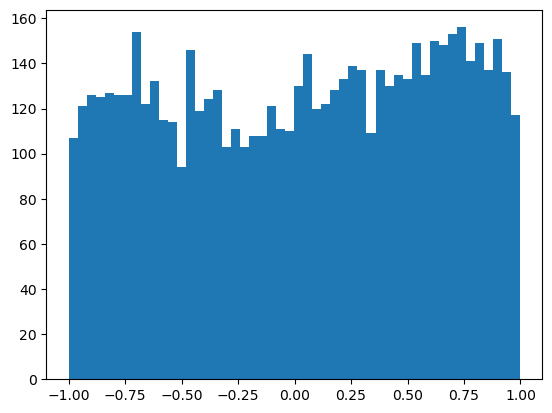

In [139]:
plt.hist(h.view(-1).tolist(),50); # a semicolon to suppress a bunch of output we don't want

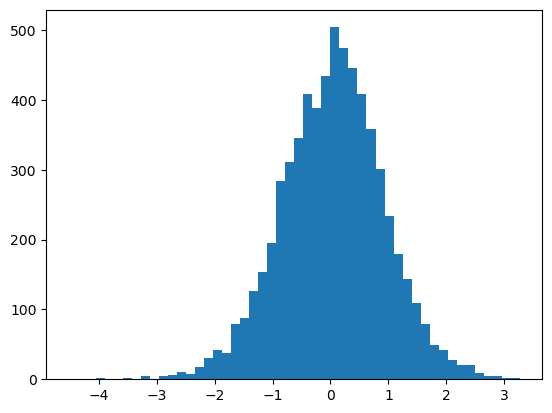

In [140]:
plt.hist(hpreact.view(-1).tolist(),50); # 激活函数前的值非常大，从-15到15，所以这些value都被squashing到-1和1

In [125]:
# def tanh(self):
#     # auto grad engine不在乎每个步骤是不是基础运算，只要定义出the derivative of the partent node with repsect to the child node即可---定义local grad
#     x = self.data
#     t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
#     out = Value(t,(self,), 'tanh')    
#     def _backward():
#         self.grad += (1 - t**2) * out.grad # chain rule : local gradient * global gradient
#     out._backward = _backward
#     return out

# 每一个value,如果tanh之后t非常接近-1或者1，那么1-t**2就是0，所以tanh就会kill掉所有global gradient,也就是local gradient为0，阻止了global gradient

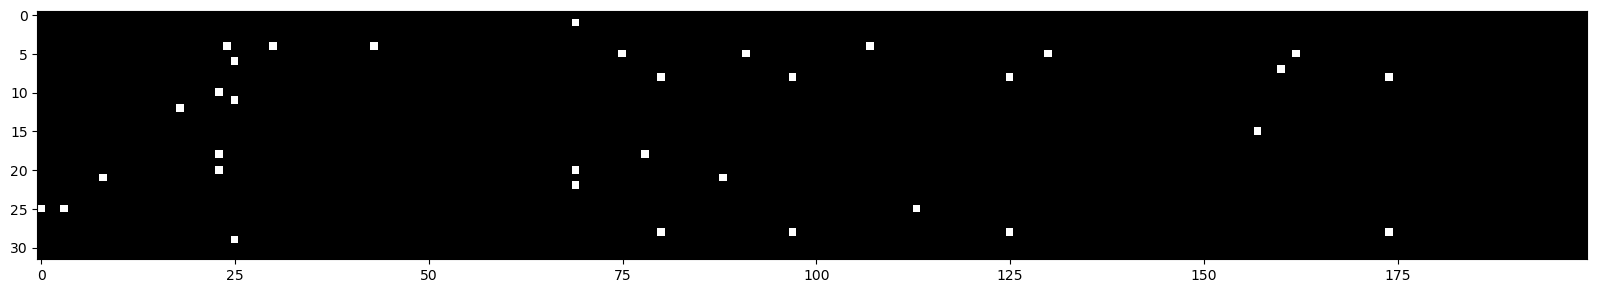

In [141]:
# 看一下h通过tanh之后有多少是大于0.99的
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest') # [32, 200] input, 200 neurons, white for True and black for False
# 大部分白色的区域，梯度会被destroyed
# 200个neuron, 当某一列全白色，表示这一个batch的所有梯度过来，都不会更新这一个neuron,表示dead tensor
# 不管什么input进来，这一个nueron是-1或者1，无法更新---- tanh dead neuron
# 不管什么input进来，这个neuron都是负数，这个relu neuron是一个dead neuron , 这个neuron的weights and bias都不会再被更新,在初始化和训练都有可能发生,训练中如果梯度太大，lr也太大，从此之后没有example可以activate这些neuron
# relu dead neuron it's like a permanent brain damage in a mind
# leaky ReLU没有flat tail,永远会有梯度

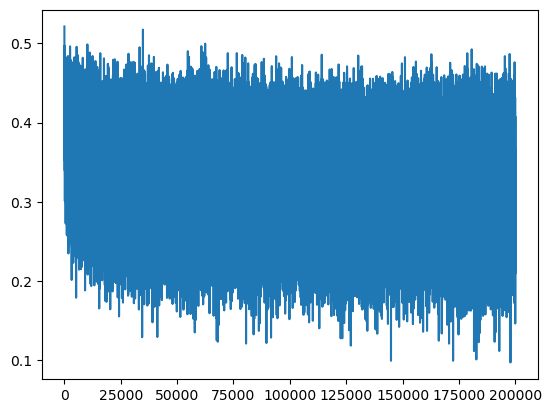

In [147]:
plt.plot(lossi)

In [146]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    h = torch.tanh(embcat@W1+b1) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('test')


train 2.10556960105896
test 2.181131601333618


In [ ]:
# loss log

# original:
train 2.2018580436706543
test 2.262258768081665

# fix softmax confidently wrong - fix projection layer initialization
train 2.1460914611816406
test 2.2219550609588623

# fix tanh layer too saturated at init - fix preactivation layer saturation 
train 2.10556960105896
test 2.181131601333618

### 4.Kaming init

当我的网络有很多很多层，每一层该怎么正确的初始化，该怎么控制W1 = torch.randn((out_fan,in_fan)) * 0.2这种参数？


tensor(0.0002) tensor(1.0040)
tensor(-0.0010) tensor(1.0193)
tensor(0.0415) tensor(1.4046)


Text(0.5, 1.0, 'Y_B')

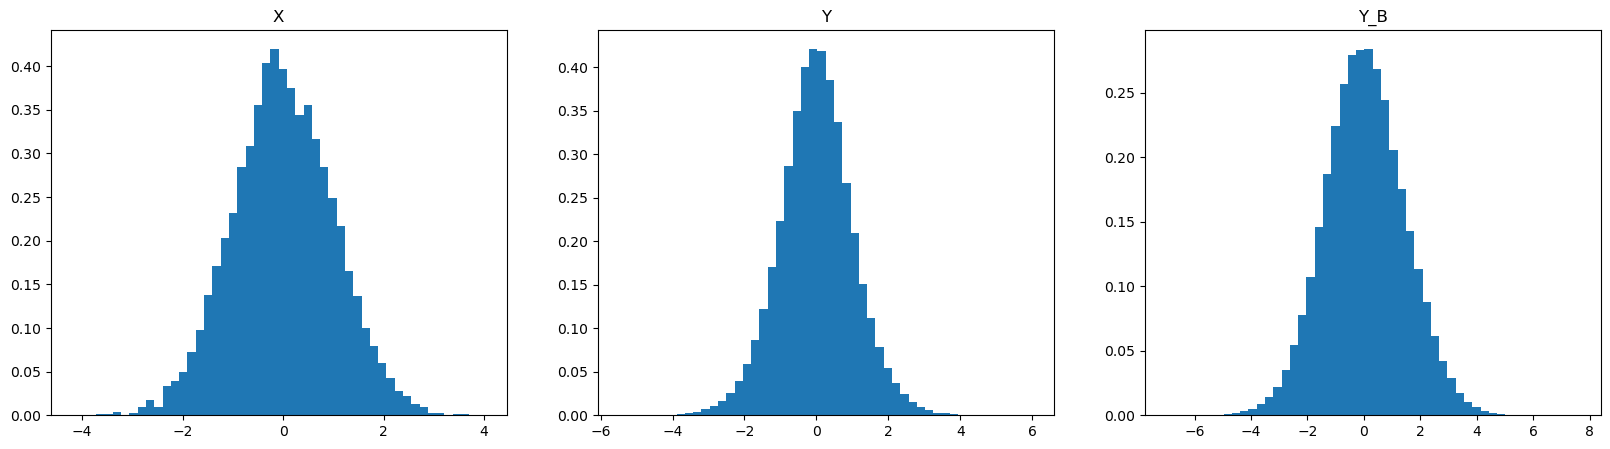

In [173]:
import math
# 很重要的一点，两个randn矩阵相乘，均值不变，但是std会变大非常多
x = torch.randn(1000,10)# random sample gaussian sample
w = torch.randn(10,200) / 10**0.5 # variance = 10 * (10**0.5)^2
b = torch.randn(200)
y = x @ w # [1000,200]
y_b = y + b
print(x.mean(),x.std())
print(y.mean(),y.std())
print(y_b.mean(),y_b.std())
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.title(f"X")
plt.subplot(132)
plt.hist(y.view(-1).tolist(),50,density=True);
plt.title(f"Y")
plt.subplot(133)
plt.hist(y_b.view(-1).tolist(),50,density=True);
plt.title(f"Y_B")

数学上如何解释这种现象？

背景:x,y是两个独立的随机变量基本公式如下
- $E[x] =\int p(x)dx,E[f(x)]=\int f(x)p(x)dx$
- $D[x] =E[x^2]-(E[x])^2 $
- $E[x+y] = E[x] + E[y]$ 如果x,y彼此独立
- $E[xy] = E[x]E[y]$
- $D(x+y) = D[x] + D[y]$
- $D[xy] == E[(xy)^2] - (E[xy])^2 = E[x^2 y^2] - (E[x]E[y])^2= E[x^2]E[y^2]-0=1$,注意$D[xy]!=D[x]D[y]$在绝大部分情况成立

form : $x_i \in N(0,1), y_i \in N(0,1)$

z = x @ y = $\sum\limits_{i=1}^N x_iy_i$ 代表矩阵相乘的每一个元素是由一组向量内积得到

$E[z] = \sum\limits_{i=1}^N E[x_iy_i]= \sum\limits_{i=1}^N E[x_i]E[y_i]=0$   
$D[z] = \sum\limits_{i=1}^N D[x_iy_i]= N$, N=10表示两个向量内积的个数 
$Var(z)=\sqrt{D[z]}=\sqrt{10}\approx3.1623$

PS : 1. a,b b,c 一共有 $a\times b\times c= 2abc$ 个浮点数操作

PS : 2. 同理w+b之后，也会使得variance进一步增大

PS : 3. 假设全是FNN,一层之后activation为$\mathcal{N}(0,N)$,两层之后为$\mathcal{N}(0,N^2)$, N为hidden layer的大小

总结: $Var[y] = nVar[w]Var[x]$

****

from : Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification

Kaming initialization

假设神经网络是一系列的MLP:$W,\bold{b}$ +激活函数$f$

$\bold{y}_L=\bold{W}_l\bold{x}_l+\bold{b}_l,\bold{x}_l=f(\bold{y}_{l-1}),\forall l \in [2,L]$ 

$\bold{y}_1=\bold{W}_1\bold{x}_1+\bold{b}_1$

考虑以下假设：  
1. $\bold{b}=0$, $\bold{W}_l$的每一个元素都是iid的,$x_l$的每一个元素都是iid的，$x_l$和$W_l$的每一个元素都是独立的   

2. $w_l$来自一个均值为0,方差为某个数的高斯分布 (symmetric distribution)   

3. $y_l$的均值在0附近，是一个对称的分布

考虑每一个元素$y_l,x_l,w_l$都是$\bold{y}_l,\bold{x}_l,\bold{W}_l$中的任意一个随机变量：

现在我们希望使得输出$y_l$的方差始终控制在一个常数，如0，对$w_l$可能的分布进行探索，主要希望控制$w_l$的初始化方差$Var[w_l]$


$Var[y_{l,i}]=\sum\limits_{k=1}^{n_l} x_{l,k}W_{l,(i,k)}$,考虑到W和x中的元素相互独立，因此可以通过方差分解      

$Var[y_l]=n_lVar[w_lx_l]=n_l(E[w_l^2x_l^2]-E[w_lx_l]^2)$,考虑到$E[w_l]=0$,则$Var[y_l]=n_lE[w_l^2x_l^2]=n_lE[w_l^2]E[x_l^2]$

考虑到对于任意随机变量$E[x^2]=D[x]-(E[x])^2$,则$E[w_l^2]=Var[w_l]$

$Var[y_l]=n_lVar[w_l]E[x_l^2]$

注意到$E[x_l^2]在多数情况不为0，特别是对于ReLU, x_l=\max(0,y_{l-1}), E[x_l]=\frac{1}{2}Var[y_{l-1}]$对于$y_{l-1}$为任意概率分布。而有无激活函数、不同激活函数会导致$E[x_l^2]$的不同，

proof : $E[x_l^2]=E[g(y)]=\int\limits_{-\infty}^{\infty}max(0,y_{l-1})^2p(y_{l-1})dy_{l-1}$其中g(y)=max(0,y_{l-1})^2

proof :$E[x_l^2]=\int\limits_{0}^{\infty}y_{l-1}^2p(y_{l-1})dy_{l-1}$只考虑$y_{l-1}>0$的部分,且p(y)与$y_2$都是对称，因此有:

proof :$E[x_l^2]=\frac{1}{2}\int\limits_{-\infty}^{\infty}y_{l-1}^2p(y_{l-1})dy_{l-1}= \frac{1}{2}E[y_{l-1}^2]=\frac{1}{2}Var[y_{l-1}]$,由于$E[y_{l-1}]=0$

因此$Var[y_l]=\frac{1}{2}n_lVar[w_l]Var[y_{l-1}]$

- 如果无激活函数，可以看作$x_l=y_{l-1},E[x_l]=E[y_{l-1}]=0,Var[y_{l-1}]=Var[x_l]=E[x_l^2]$, $Var[y_l]=n_lVar[w_l]Var[y_{l-1}]$

$n_l$前面的系数称为gain,是不同激活函数的期望带来的结果

如果有L层放在一起,这样导致复杂度通过$n_l$指数增加

$Var[y_L]=Var[y_1](\Pi_{l=2}^L \frac{1}{2}n_lVar[w_l])$  

这样如果想要每一层$\frac{1}{2}n_lVar[w_l]=1;Var[w_l]=\frac{2}{n_l}$,

对于第一层相当于没有ReLU函数，因此$n_1Var[w_1]=1$，但是$Var[w_1]=\frac{2}{n_1}$简化了代码

同时作者发现，当使用这种初始化方式初始化forward propagation的时候，backward梯度同样也近似正确的初始化



-----


Same idea also in transformer, attention score = $\frac{QK^T}{\sqrt{d_k}}$, as $qk^T$ has mean 0 and vadiance d_k

In [188]:
x = nn.Linear(10,10)

In [189]:
x.bias

Parameter containing:
tensor([-0.1754,  0.1014, -0.1699, -0.0982,  0.1684,  0.2071,  0.2008,  0.0628,
        -0.2355, -0.0386], requires_grad=True)

In [182]:
# FFN在参数全是均匀高斯分布的情况下，会explore
x = torch.randn(10000,16)# random sample gaussian sample
w1 = torch.randn(16,16) 
w2 = torch.randn(16,16)
w3 = torch.randn(16,16)
y1 = x @ w1
y2 = y1 @ w2
y3 = y2 @ w3
print(x.mean(),x.var())
print(y1.mean(),y1.var())
print(y2.mean(),y2.var())
print(y3.mean(),y3.var()) # 可以明显的看到参数variance会explode

tensor(0.0025) tensor(1.0019)
tensor(-0.0025) tensor(15.1803)
tensor(0.0199) tensor(199.1286)
tensor(0.0840) tensor(3066.2524)


In [158]:
# 深度学习都是一些矩阵操作block,如何设置初始化使得activation value都是合理的

# andrej，现在有很多种方法使得训练非常稳定，所以一个非常精确的初始化似乎不那么重要，大致上只需要除以根号下n就可以
# 1. residue connections, 
# 2. normalizations
# 3. 更好的optimizer

tensor(3.1623)

In [191]:
(torch.randn(10000) * 0.2 ).std() # torch.randn()*的值表示控制std,比如NeMO项目中控制噪音的标准差

tensor(0.1970)

In [192]:
# tanh进行初始化的时候，gain=5/3, 
(5/3) / (30**0.5)

0.3042903097250923

In [193]:
# 重新看我们的初始化和代码------核心目标，希望logits最后在零附近,不要变成extreme value
# 1.为什么大部分模型的projection layer, bias都为False
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g) * (5/3)*(n_embd*block_size)**0.5 # kaming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


通过kaming initial，我们初始化的时候不需要猜一个标准差数值，而是有一些semi-principled方法来确定每一层初始化的方差大致应该是多少，特别是那些对应不同激活函数的weight

### 5.Batch normalization

正是因为有了这些normalization,才使得现代训练神经网络非常可靠

In [2]:
# from hekaiming normalization methods
# link : https://drive.google.com/file/d/1mSm1i1xhI9FlXypM9VsJqcllD4XjyPFi/view

# basic normalization module in most Conv,Transformer: [linear -> norm -> relu] 核心：必须在activation前面加上norm
# in [norm] : compute E[x],Var[x], normalize, compensate by a linear transformation

# in megatron GPT2 standard transformer, they use layer normalization before linear
# Attention : x = x + Dropout(MHA(LN(x)))
# FFN :   x = x + Dropout(W2(GeLU((W1(LN(x))+b))+b2)) 

# 不同的normlization在计算均值和方差的时候有所不同

N = 16
C = 256
H = 32
W = 32

x = torch.randn(N,C,H,W)

bn_x_mean = torch.einsum("nchw->c",x) / (N*H*W) # BN at inference time 1. batch N axis is not legitimate 2. using moving average to mainin \mu and \sigma in training, using in inference 

ln_transformer_x_mean = torch.einsum("nchw->nhw",x) / C # LN in a token

ln_ConvNet_x_mean = torch.einsum("nchw->n",x) / (C*H*W) # LN in a sample

in_x_mean = torch.einsum("nchw->nc",x) / (H*W) # IN in a H,W of a channenl of a sample

In [4]:
# in pytorch
# BN1D for 2D tensor - tabuler data [N,C], and 3D sequence tensor Batch,channel,sequence [N,C,L]

# With Learnable Parameters
N = 20
C = 100
L = 32
m = nn.BatchNorm1d(C)
# Without Learnable Parameters
x_in1 = torch.randn(N, C)
x_in1_bn = m(x_in1) # average over N
x_in2 = torch.randn(N, C, L)
x_in2_bn = m(x_in2) # average over N,L


# BN2D for 4D tensor - image data [N,C,H,W]
N,C,H,W = 20,100,32,32
m = nn.BatchNorm2d(C)
x_in = torch.randn(N, C, H, W) # average on N H W

# BN3D for 5D tensor - video data [N,C,D,H,W]
N,C,D,H,W = 20,100,10,32,32
m = nn.BatchNorm3d(C)
x_in = torch.randn(N, C, D, H, W) # average on N D H W

In [5]:
# LayerNorm
# NLP Example
# Normalize over the last one dimension -- token embedding dimension
B, L, C = 20, 5, 10
embedding = torch.randn(B, L, C)
layer_norm = nn.LayerNorm(C)
# Activate module
layer_norm(embedding)
# Image Example
N, C, H, W = 20, 5, 10, 10
image = torch.randn(N, C, H, W)


# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(image)

In [58]:
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g) * (5/3)/(n_embd*block_size)**0.5 # kaming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0


bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


### BN的历史


1. 出发点：Linear之后，对于hpreact在初始化的时候不想太小或者太大，这样就没有梯度了，我们想让他大致成为高斯分布，至少在初始化的时候大致成为高斯分布.

2. BN的优点1: 使得初始化和训练更加稳定。在初始化的时候将pre activation变成标准高斯，而在神经网络学习的过程中不需要强迫pre activation为标准高斯，而是让网络自己学习，使得有些feature分布更sharp，有些更diffuse，有些tanh neuron更容易激活，有些tanh neuron不容易激活 -- 通过normalize和scale,shift实现

3. BN的优点2: 增加了噪音，减少了过拟合的风险。因为有了batchnormalization的存在，同一个样本，由于随机采样的原因，不同的batch samples都会影响这个样本，使得训练过程不再是一个deterministic的过程，同一个样本在不同batch会得到略微不同的不同的logits，这使得神经网络的训练增加了噪音，降低了模型过拟合的风险

4. BN的缺点1：由于BN需要在forward pass的时候将一个batch的数据联系起来，我们只希望同一个batch的数据是独立处理的；BN的这种耦合一个batch不同数据的方法会造成一些奇怪的问题。人们用layer normalization, instance normalization和group normalization来代替

5. BN的缺点2: 推理的时候不存在batch维度，需要在训练的时候维护一个全局的mean std, 作为buffer，一般使用moving average的方法一边训练一边保存

虽然BN现在被替代，但是作为第一个normalization的方法，他的效果非常好，不仅能够稳定训练还能提升模型鲁棒性，但是由于需要将batch的数据联系在一起，人们想要替代他。

"deceivingly as a second order effect"

In [59]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 # + b1 # 实际上b1是没有必要的，因为BN会将b1的作用给消除掉

    # ---code---
    bnmeani = hpreact.mean(dim=0,keepdim=True)
    bnstdi = hpreact.std(dim=0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias# BN
    # ---code---

    # ---code---
    with torch.no_grad():
        # optimizing buffer in a running manner, moving average  
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---code---

    h = torch.tanh(hpreact) # h很多在1,-1之间，因此需要将hpreact变成离零很近的数值
    logits = h @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())

    # ---DEBUG---
    # break
    

      0 /  200000: 3.3020
  10000 /  200000: 2.1588
  20000 /  200000: 2.1916
  30000 /  200000: 2.0657
  40000 /  200000: 2.2091
  50000 /  200000: 2.0517
  60000 /  200000: 2.3915
  70000 /  200000: 2.0307
  80000 /  200000: 2.2759
  90000 /  200000: 2.0076
 100000 /  200000: 2.4047
 110000 /  200000: 2.2895
 120000 /  200000: 2.1655
 130000 /  200000: 2.2173
 140000 /  200000: 2.2436
 150000 /  200000: 1.9279
 160000 /  200000: 2.1676
 170000 /  200000: 2.1694
 180000 /  200000: 2.3944
 190000 /  200000: 2.7408


In [60]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.reshape(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std of hpreact
    bnmean = hpreact.mean(dim=0,keepdim=True)
    bnstd = hpreact.std(dim=0,keepdim=True)

In [64]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    hpreact = embcat@W1+b1
    # hpreact = (hpreact - hpreact.mean(dim=0,keepdim=True)) / hpreact.std(dim=0,keepdim=True) # BN
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.1243391036987305
val 2.1653199195861816


### BN quick notes
1. $epsilon=1e-5$避免variance变成0
2. BN前面的线性层加入bias是一种浪费，相当于batch个数据，每一个维度都加入一个fix number,因此检查b1的梯度时发现梯度全部为0。所以BN前面的Linear, Conv都应该不使用bias, BN自己的bias会控制output分布shift


Q : 关于bias的设置
1. bias设置为False : e.g. 在BN之前，这些linear layers的bias会被BN抵消
2. bias设置为True : e.g. 在softmax之前，logits初始化全为0，表示模型最开始预测的是均匀分布，而不是让模型随机logits通过softmax得到置信的错误结果,这样不会让模型浪费时间在squashing参数上

### 6. ResNet 50 examples

1. 网络由很多层block组成，每一个block的架构都是conv->bn->relu ,而conv的bias都是false，表示BN之前关掉bias

2. convolution layers are actually linear layers in patches

3. Pytorch自带的Linear weight (output,input), (fan_out,fan_in), 默认gain=1,默认初始化U(-k,k), $k=\frac{1}{\sqrt{fan\_in}}$, 忽视了不同activation function带来mean, variance的差别,同时没有使用高斯分布初始化. 系数来自kaming initialization的$Var[y]=nVar[wx]$

0.01


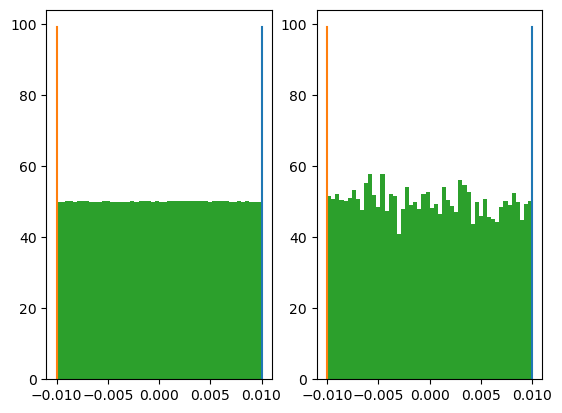

In [2]:
# nn.Linear plot the weight and bias distribution
fan_in = 10000 
fan_out = 10000
x = nn.Linear(fan_in,fan_out)
k = 1/fan_in**0.5
# plot  y=k, y=-k
plt.subplot(121)
plt.plot([k]*100,range(0,100))
plt.plot([-k]*100,range(0,100))
plt.hist(x.weight.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.plot([k]*100,range(0,100))
plt.plot([-k]*100,range(0,100))
plt.hist(x.bias.view(-1).tolist(),50,density=True);
print(k)

In [ ]:
# nn.batchnorm1d
x = nn.BatchNorm1d(100,eps=1e-5,momentum=0.1,affine=True)
# momentum表示moving average每次更新batch mean, batch std的比例
# 本文用的momentum是0.0001，因为batch size非常小，每次计算batch mean std会差异非常大 ; 如果batchsize很大，这个momentum可以设置的比较大
# affine表示需要一个可学习的参数,一般都要设置为True,andrej也不理解为什么要设置为False


### 7. Pytorch code

In [80]:
# nn.Linear
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn(fan_out,fan_in) / fan_in**0.5 ## norm with kaming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight.T
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# nn.BatchNorm1d
class BatchNorm1d:

    def __init__(self,dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self,x):
        if self.training:
            xmean = x.mean(dim=0,keepdim=True)
            std = x.std(dim=0,keepdim=True)
        else:
            xmean = self.running_mean
            std = self.running_var
        xhat = (x - xmean) / (std + self.eps)
        self.out = self.gamma * xhat + self.beta # out module for visualization
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * std
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483467)

C = torch.randn(vocab_size, n_embd,             generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer : make less confident, just uniform at the initialization
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # 现在的最后一层softmax前weight是gamma
    # all other layers : apply gain due to tanh activation
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1 # 5/3,有了BN之后gain就不重要l

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


经验之谈：不加入BN，必须谨慎调节神经网络初始化的各种方法，而BN可以放在tanh之前，也可以放在tanh之后，甚至在最后算loss，softmax之前也可以加入BN

In [81]:
# same optimization at last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.reshape(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    
    # loss computation
    loss = F.cross_entropy(x,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # 检查每次更新数据的大小
    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())

    # ---DEBUG---
    if i >= 1000:
        break

      0 /  200000: 3.2892


layer 2 tanh : mean 0.002 std 0.625, saturated 3.094%
layer 5 tanh : mean 0.000 std 0.635, saturated 3.125%
layer 8 tanh : mean 0.005 std 0.646, saturated 2.344%
layer 11 tanh : mean -0.004 std 0.645, saturated 2.250%
layer 14 tanh : mean -0.002 std 0.654, saturated 1.500%


Text(0.5, 1.0, 'Tanh activation distribution')

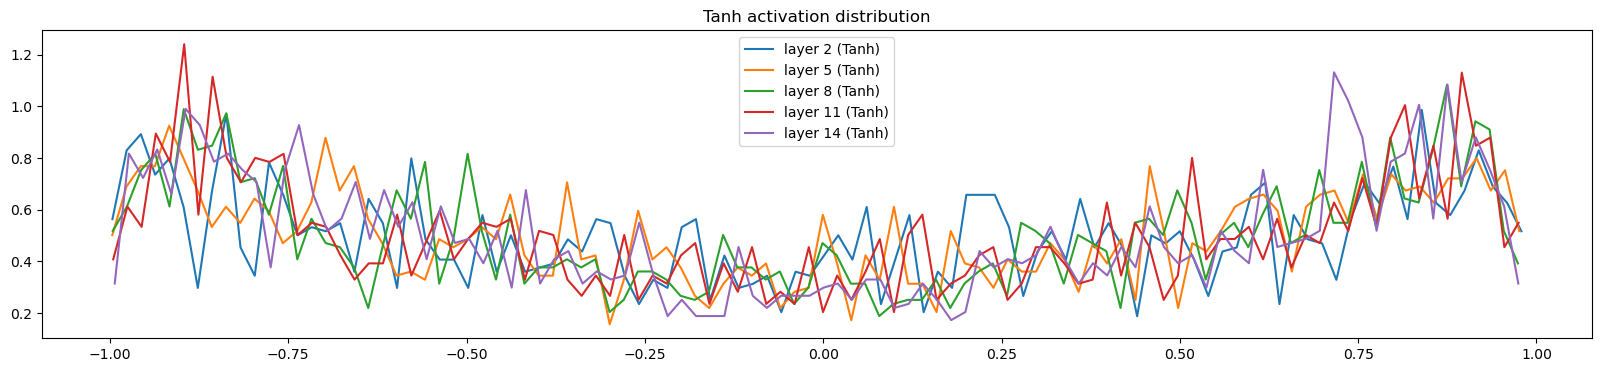

In [82]:
# nn visualization : activation values , gradients, weights, update data ratio
# visualize tanh output histograms
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):# note : exlude the output layer
    if isinstance(layer,Tanh):
        t = layer.out
        print(f"layer {i} tanh : mean {t.mean().item():.3f} std {t.std().item():.3f}, saturated {(t.abs()>0.97).float().mean()*100 :.3f}%")
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Tanh activation distribution")

# 注意histogram是一个pdf,积分为1即可,hx表示bin的左边界,hy表示pdf的值
# pdf要求非负，积分为1

layer 0 Linear : mean 0.037 std 0.815%
layer 3 Linear : mean 0.002 std 0.729%
layer 6 Linear : mean 0.002 std 0.793%
layer 9 Linear : mean -0.003 std 0.774%
layer 12 Linear : mean -0.004 std 0.762%
layer 15 Linear : mean 0.005 std 1.219%


Text(0.5, 1.0, 'Linear activation distribution')

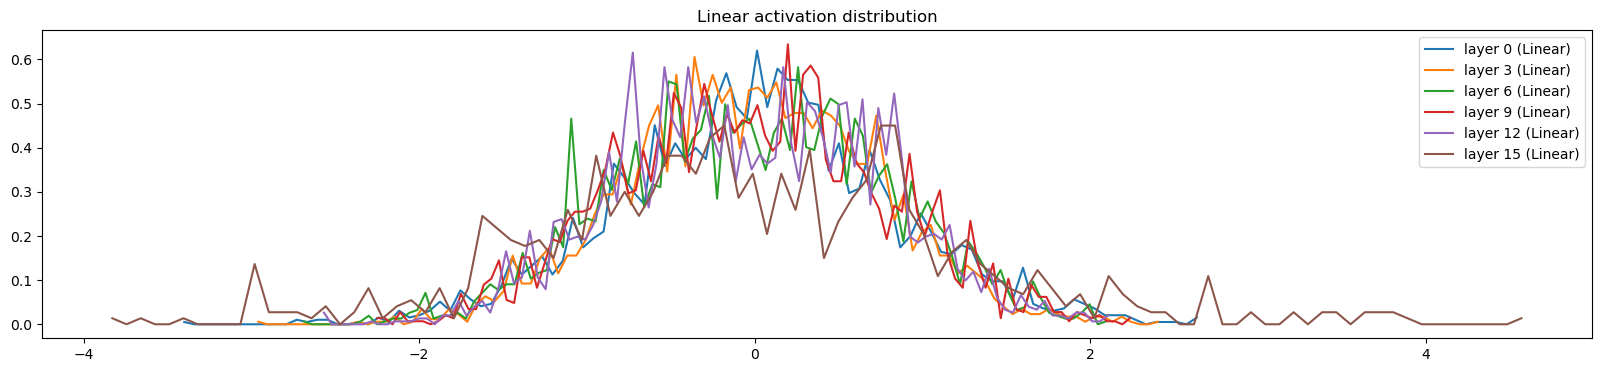

In [83]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):# note : exlude the output layer
    if isinstance(layer,Linear):
        t = layer.out
        print(f"layer {i} {layer.__class__.__name__} : mean {t.mean().item():.3f} std {t.std().item():.3f}%")
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Linear activation distribution")

layer 2 Tanh : mean 0.000 std 0.003
layer 5 Tanh : mean -0.000 std 0.002
layer 8 Tanh : mean 0.000 std 0.002
layer 11 Tanh : mean 0.000 std 0.002
layer 14 Tanh : mean 0.000 std 0.002


Text(0.5, 1.0, 'Linear activation distribution')

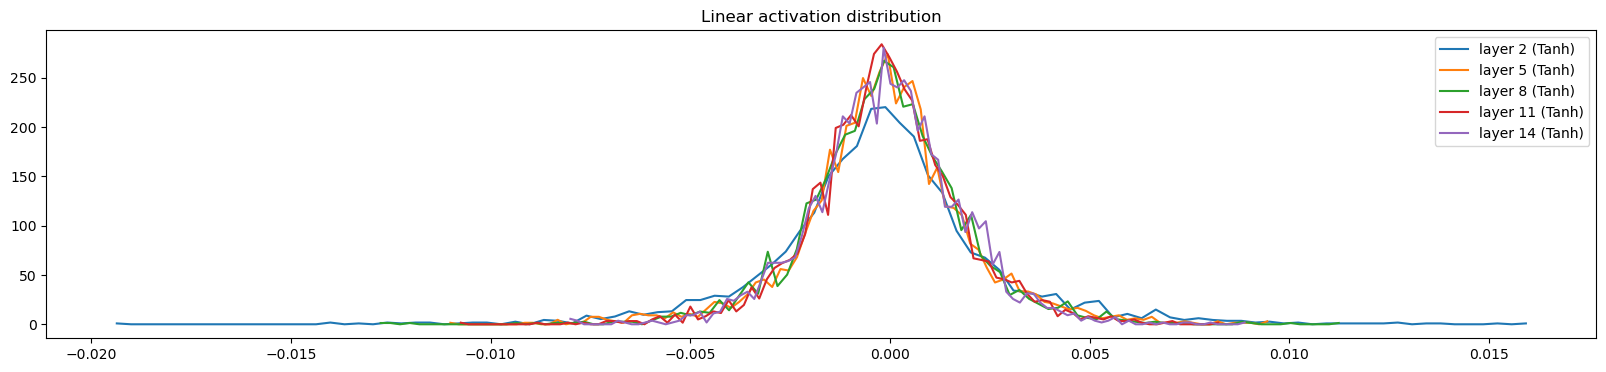

In [84]:
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):# note : exlude the output layer
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print(f"layer {i} {layer.__class__.__name__} : mean {t.mean().item():.3f} std {t.std().item():.3f}")
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Linear activation distribution")

weight (27, 10) | mean 0.000 std 0.011,  grad:data ratio 0.012
weight (100, 30) | mean 0.000 std 0.009,  grad:data ratio 0.051
weight (100, 100) | mean 0.000 std 0.006,  grad:data ratio 0.059
weight (100, 100) | mean 0.000 std 0.005,  grad:data ratio 0.052
weight (100, 100) | mean 0.000 std 0.005,  grad:data ratio 0.049
weight (100, 100) | mean 0.000 std 0.005,  grad:data ratio 0.047
weight (27, 100) | mean 0.000 std 0.010,  grad:data ratio 0.097


Text(0.5, 1.0, 'Weight gradients distribution')

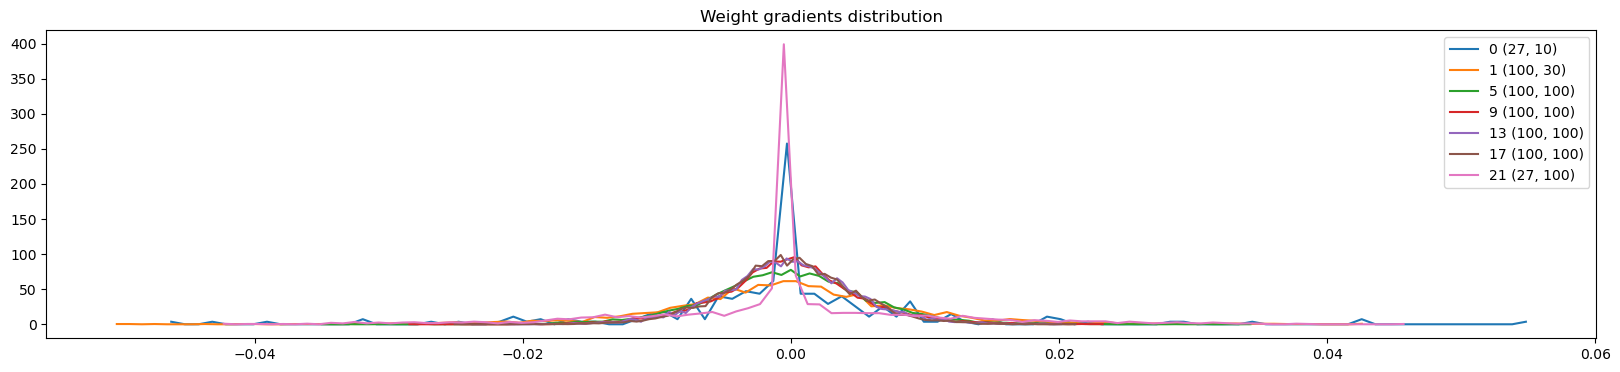

In [85]:
# parameters and update ratio
# last layers are much larger gradients and gradient std, 这导致只使用普通的优化器如Adam并不好，需要使用一些高级的优化器比如adam
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        # only wegiths
        print(f"weight {tuple(p.shape)} | mean {t.mean().item():.3f} std {t.std().item():.3f},  grad:data ratio {t.std() / p.std() :.3f}")
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weight gradients distribution")

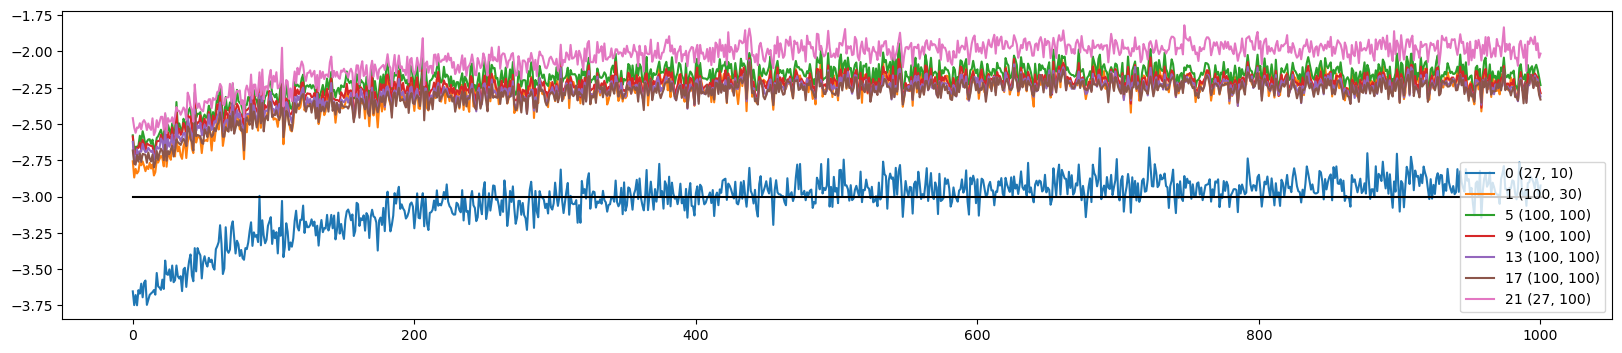

In [86]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))]) # 1001步更新，每一步更新第i个参数时的更新比例和数据比例
        legends.append(f"{i} {tuple(p.shape)}")
plt.plot([0,len(ud)],[-3,-3],'k') # ratio 1e-3 is a good ratio, small to big lr, big to slow the lr in 10 magnitue 
plt.legend(legends)
# 所有的参数以大致相同的速度训练

有了BN之后，参数的初始化不再那么重要，activation, gradient, weights都在合理的范围，但是可能需要调节一下学习率使得网络训练在一个合理的范围。训练变得更加稳定，不需要gain，甚至可能不需要fan_in调节